In [1]:
import os
import re
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.patches as mpatches

import datetime
from typing import Union

from wordcloud import WordCloud, STOPWORDS

In [2]:
sns.set_theme(style="whitegrid",font_scale=2)

## Analyze All Data

In [3]:
file_list = os.listdir(os.path.abspath('./data'))
csv_files = [k for k in file_list if '.csv' in k]
print(csv_files)

df = pd.concat([pd.read_csv("".join(['./data/',f]),index_col=0) for f in csv_files ], ignore_index=True)

['file.csv']


### Cleanup some parts

In [4]:
# scraping may have resulted in some duplicates (e.g. result match multiple search)
# maybe we cant casually drop duplicates because timestamps included arent down to the second...
# df = df.drop_duplicates()

In [5]:
df['decdate'].fillna(df['date_add'], inplace=True)
df['decdate_ts'].fillna(df['date_add_ts'], inplace=True)
df['decdate_ts'] = df['decdate_ts'].astype('int')

In [6]:
def vec_dt_replace(series, year=None, month=None, day=None):
    return pd.to_datetime(
        {'year': series.dt.year if year is None else year,
         'month': series.dt.month if month is None else month,
         'day': series.dt.day if day is None else day})

In [7]:
df_1720 = df[(df['season'].isin(['Fall 2018', 'Fall 2019', 'Fall 2020', 'Fall 2021','Fall 2022','Fall 2023']))]

In [8]:
df.columns

Index(['institution', 'major', 'degree', 'season', 'decisionfin', 'method',
       'decdate', 'decdate_ts', 'gpa', 'grev', 'greq', 'greaw', 'status',
       'date_add', 'date_add_ts', 'comment'],
      dtype='object')

### Make it easier to filter through programs using the decision, the institution, gre, gpa, etc.

In [9]:
def create_filter(df,
                  degree: str = None,
                  decisionfin: Union[str, list] = None,
                  institution: Union[str, list] = None,
                  prog: Union[str,list] = None,
                  gpa: bool = False):
    filt = [True] * len(df)
    if degree is not None:
        filt = (filt) & (df['degree'] == degree)
    if prog is not None:
        if isinstance(prog, str):
            filt = (filt) & (df['major'].str.contains(prog, case=False))
        elif isinstance(prog, list):
            filt = (filt) & (df['major'].str.lower().isin([x.lower() for x in prog]))
    if decisionfin is not None:
        if isinstance(decisionfin, str):
            filt = (filt) & (df['decisionfin'].str.contains(decisionfin, case=False))
        elif isinstance(decisionfin, list):
            filt = (filt) & (df['decisionfin'].str.lower().isin([x.lower() for x in decisionfin]))
    if institution is not None:
        if isinstance(institution, str):
            filt = (filt) & (df['institution'].str.contains(institution, case=False))
        elif isinstance(institution, list):
            filt = (filt) & (df['institution'].str.lower().isin([x.lower() for x in institution]))
    if gpa:
        filt = (filt) & (~df['gpa'].isna()) & (df['gpa'] <= 4)
    
    return filt

### Actual function that generates the images

In [10]:
def get_uni_stats(u_df, 
                  histype: str = None, 
                  search: str = None, 
                  major: str = None,
                  title: str = None, 
                  degree: str = '', 
                  field: str = '', 
                  hue='decisionfin'
                 ):
    title = title if title is not None else search
    if degree not in ['MS', 'PhD', 'MEng', 'MFA', 'MBA', 'Other']:
        degree = 'Other'
        
    # Clean up the data a bit, this probably needs a lot more work
    # Maybe its own method, too
    u_df = u_df.copy()
    u_df = u_df[~u_df['decdate'].isna()]
    
    u_df.loc[:,'year'] = pd.to_numeric(u_df['decdate'].str[-4:],errors='coerce')
    u_df = u_df.dropna(subset=['year'])
        
    u_df = u_df[(u_df['year'] > 2000) & (u_df['year'] < datetime.datetime.now().year)]
    
    # Normalize to 2020. 2020 is a good choice because it's recent AND it's a leap year
    u_df.loc[:, 'uniform_dates'] = vec_dt_replace(pd.to_datetime(u_df['decdate'],dayfirst=True), year=2020)
    
    # Get december dates to be from "2019" so Fall decisions that came in Dec come before the Jan ones.
    dec_filter = u_df['uniform_dates'] > datetime.datetime.strptime('2020-11-30', '%Y-%m-%d')
    u_df.loc[dec_filter, 'uniform_dates'] = vec_dt_replace(pd.to_datetime(u_df[dec_filter]['uniform_dates']), year=2019)
    
    # Trying to pick red/green colorblind-friendly colors
    flatui = ["#00A36C", "#C21E56", "#FFC300"]
    sns.set_palette(flatui)
    acc_patch = mpatches.Patch(color='#00A36C80')
    rej_patch = mpatches.Patch(color='#C21E5680')
    int_patch = mpatches.Patch(color='#FFC30080')
    acc_line = mlines.Line2D([], [], color='#00A36C')
    rej_line = mlines.Line2D([], [], color='#C21E56')
    int_line = mlines.Line2D([], [], color='#FFC300')
    
    status_type = ['Accepted', 'Rejected', 'Interview']

    hue_order = status_type
    
    if hue == 'status':
        hue_order = ['American', 'International', 'Other']
        status_type = ['Accepted', 'Interview']
    
    # No more GRE, so we do 2x1
    fig,ax = plt.subplots(1,2)
    fig.set_size_inches(20,10)
    
    # Timeline stats
    mscs_filt = create_filter(u_df, degree, status_type, institution = search, prog = major)
    mscs_filt = (mscs_filt) & (u_df['uniform_dates'].astype(str) <= '2020-06-00')
    
    if histype == 'ecdf':
        stat = "count"
        sns.ecdfplot(data=u_df[mscs_filt],
                     x='uniform_dates',
                     stat=stat,
                     hue=hue,
                     hue_order=hue_order,
                     ax=ax[0]
                    )
    else:
        sns.histplot(data=u_df[mscs_filt],
                     x='uniform_dates',
                     element='step',
                     hue=hue,
                     cumulative=True,
                     discrete=False,
                     fill=False,
                     hue_order=hue_order,
                     ax=ax[0]
                    )

    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    formatter.formats = ['%b',  # years
                         '%b',       # months
                         '%d',       # days
                         '%H:%M',    # hrs
                         '%H:%M',    # min
                         '%S.%f', ]  # secs
    # Hide the year
    formatter.zero_formats = ['%b',  # years
                         '%b',       # months
                         '%d',       # days
                         '%H:%M',    # hrs
                         '%H:%M',    # min
                         '%S.%f', ]  # secs
    # Hide the year
    formatter.offset_formats = ['',  # years
                         '',       # months
                         '%d',       # days
                         '%H:%M',    # hrs
                         '%H:%M',    # mins
                         '%S.%f', ]  # secs
    
    ax[0].xaxis.set_major_locator(locator)
    ax[0].xaxis.set_major_formatter(formatter)
    h, l = ax[0].get_legend_handles_labels()
    
    # Add frequency counts
    if h is not None and l is not None:
        if hue == 'decisionfin':
            counts = u_df[mscs_filt][hue].value_counts().reindex(hue_order)
            l = [f'{value} (n={count})' for value, count in counts.items()]
            ax[0].legend(handles=[acc_line, rej_line, int_line], labels=l, title="Decision")

    ax[0].set_xlabel("Date")
    ax[0].set_ylabel("Count")
    ax[0].set_title("Cumsum of decisions")
    
    # Get GPA stats
    mscs_filt = create_filter(u_df, degree, status_type, institution = search, prog = major, gpa = True)
    
    sns.histplot(data=u_df[mscs_filt],
                 multiple="stack",
                 x='gpa',
                 hue=hue,
                 hue_order=hue_order,
                 bins=20,
                 ax=ax[1]
                )
    ax[1].set_xlabel("GPA")
    ax[1].set_ylabel("Count")
    ax[1].set_title("GPA Distribution")
    
    # Add frequency counts
    #h, l = ax[0][1].get_legend_handles_labels()
    h, l = ax[1].get_legend_handles_labels()
    if h is not None and l is not None:
        if hue == 'decisionfin':
            counts = u_df[mscs_filt][hue].value_counts().reindex(hue_order)
            l = [f'{value} (n={count})' for value, count in counts.items()]
            ax[1].legend(handles=[acc_patch, rej_patch, int_patch], labels=l, title="Decision")
    
    # Save file to output directory
    fig.suptitle(title + ', ' + field + ' ' + degree, size='xx-large')
    plt.savefig('output/' + title + '_' + field + '_' + degree + '.png')
    fig

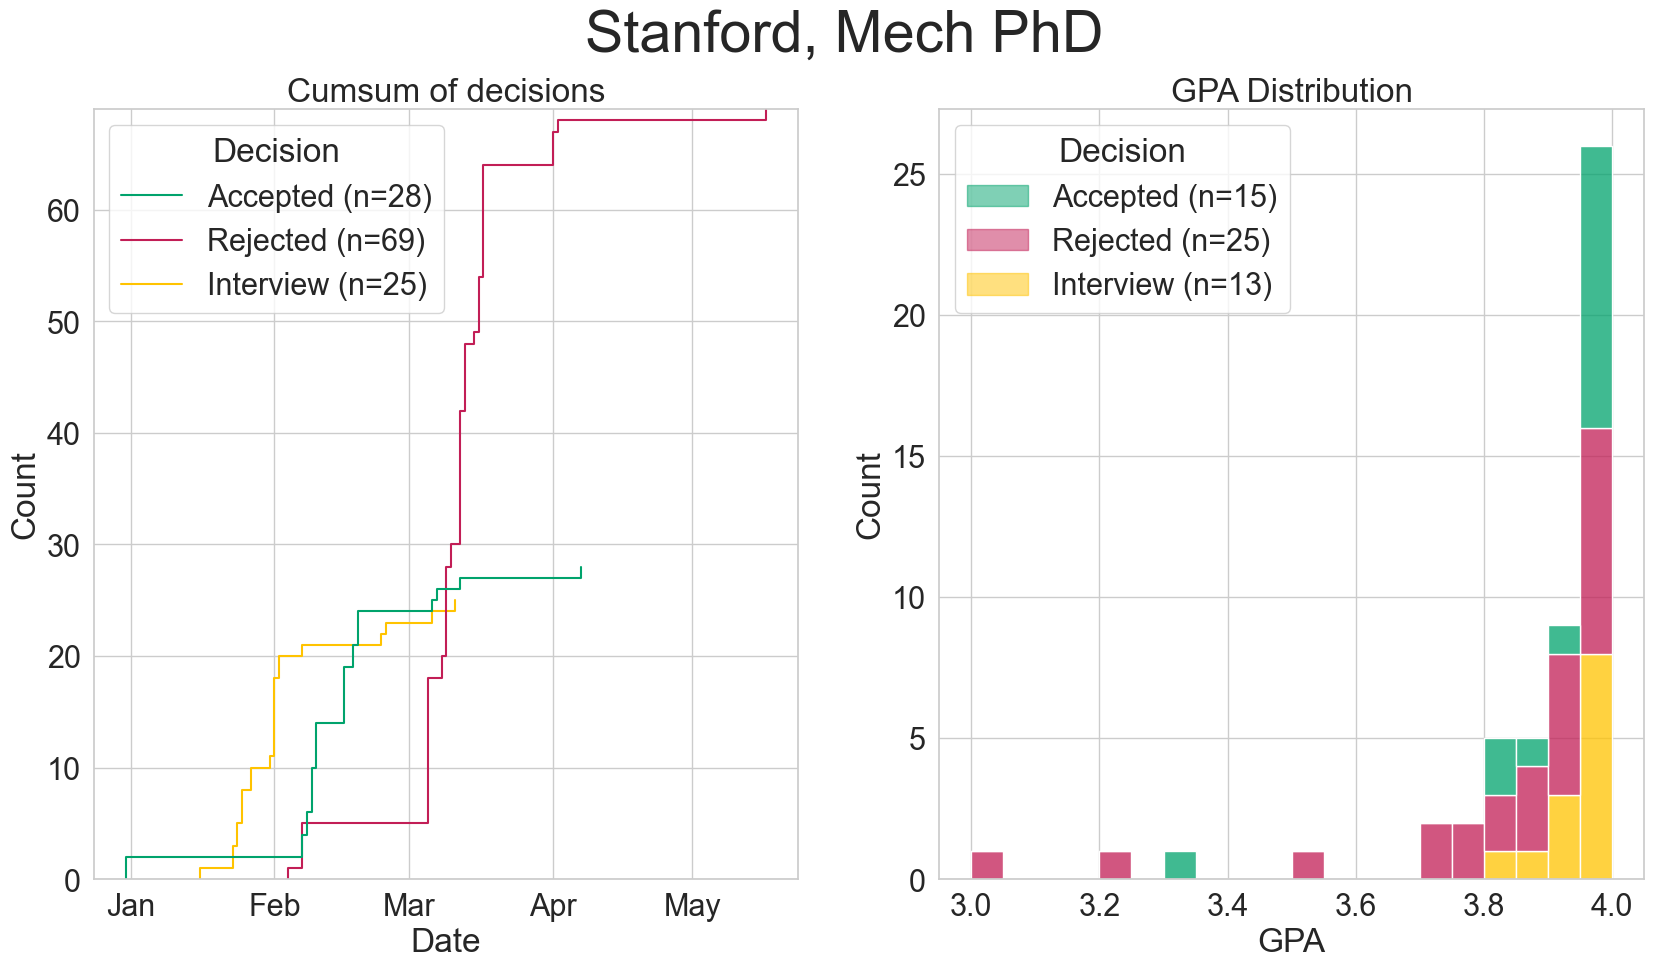

In [11]:
# Change 'search' accordingly
# histype='ecdf' for increased granularity
get_uni_stats(df_1720, histype='ecdf', search='Stanford', major='Mech', title='Stanford', degree='PhD', field='Mech')

## Other things you could analyze

For instance how many interviews per university, and thus know how likely it is that the interview process is a must if you wanna be accepted.

### Bad interview analysis

Calculate the ratio of interviews to acceptances: if close to or greater than 1, likely indicative that most candidates are accepted only after interview. However, note that a lot of people reach out to PI before applying and do interviews pre-emptively, which are unlikely to be reported here.

In [12]:
df_1720['is_int'] = 0
df_1720['is_acc'] = 0
df_1720.loc[df_1720['decisionfin'] == 'Interview', 'is_int'] = 1
df_1720.loc[df_1720['decisionfin'] == 'Accepted', 'is_acc'] = 1

#df_1720.groupby(by='institution').agg({'is_int': sum}).sort_values(by='is_int', ascending=False).head(10)

In [13]:
# Mild cleanup of institution names
df_1720['short_inst'] = df['institution'].str.split('(').str[0].str.replace('[^a-zA-Z]','',regex=True)
df_1720['short_inst'] = df_1720['short_inst'].str.strip().str.lower()

# Make table of interview/acceptance
dfr = pd.DataFrame()
dfr['Institution'] = df_1720.groupby(by='short_inst')['institution'].agg(pd.Series.mode)
dfr['Interviews'] = df_1720.groupby(by='short_inst').agg({'is_int':sum})
dfr['Acceptances'] = df_1720.groupby(by='short_inst').agg({'is_acc':sum})

# Ratio of interview to acceptance
dfr = dfr.loc[~((dfr['Acceptances'] == 0))]
dfr['Ratio'] = dfr['Interviews']/dfr['Acceptances']

dfr.sort_values(by='Interviews', ascending=False).head(16).reset_index(drop=True)

,Institution,Interviews,Acceptances,Ratio
0,Stanford University,41,139,0.294964
1,"University of Colorado, Boulder",30,94,0.319149
2,"University Of California, Berkeley",29,97,0.298969
3,Princeton University,25,32,0.781250
4,University of Michigan (Ann Arbor),24,202,0.118812
5,Carnegie Mellon University,23,106,0.216981
6,California Institute of Technology,19,22,0.863636
7,Columbia University,19,43,0.441860
8,Purdue University - West Lafayette,17,90,0.188889
9,University Of Washington,16,79,0.202532


### Decisions on what day of the week?

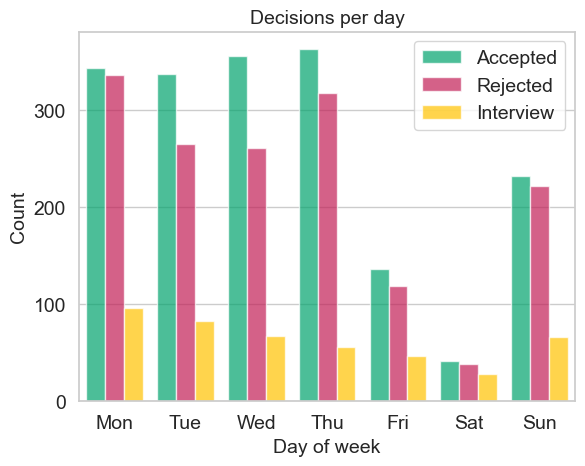

In [14]:
flatui = ["#00A36C80", "#C21E5680", "#FFC30080"]
sns.set_palette(flatui)
    
hue_order = ['Accepted', 'Rejected', 'Interview']   
day_order = ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]

df_1720['day'] = pd.to_datetime(df['decdate_ts'], unit='s').dt.day_name().str[0:3]
df_filt = create_filter(df_1720, 'PhD', hue_order)

g = sns.countplot(data=df_1720[df_filt],
                  x='day',
                  hue='decisionfin',
                  hue_order=hue_order,
                  order=day_order,
                  saturation=1,
                  alpha=0.7
                 )

g.set_xlabel("Day of week")
g.set_ylabel("Count")
g.set_title("Decisions per day")
    
for item in ([g.title, g.xaxis.label, g.yaxis.label] +
             g.get_xticklabels() + g.get_yticklabels()):
    item.set_fontsize(14)
g.legend(fontsize=14);

g.get_figure().savefig("output/days.png")

# Analyze the entire dataset

In [15]:
hisdf = df

# Here we filter out old GRE scores so that it does not mess up the box plots
#hisdf = df[((df['greq'] <= 170) | (df['greq'].isnull())) & ((df['grev'] <= 170) | (df['grev'].isnull()))]

In [16]:
hisdf.columns

Index(['institution', 'major', 'degree', 'season', 'decisionfin', 'method',
       'decdate', 'decdate_ts', 'gpa', 'grev', 'greq', 'greaw', 'status',
       'date_add', 'date_add_ts', 'comment'],
      dtype='object')

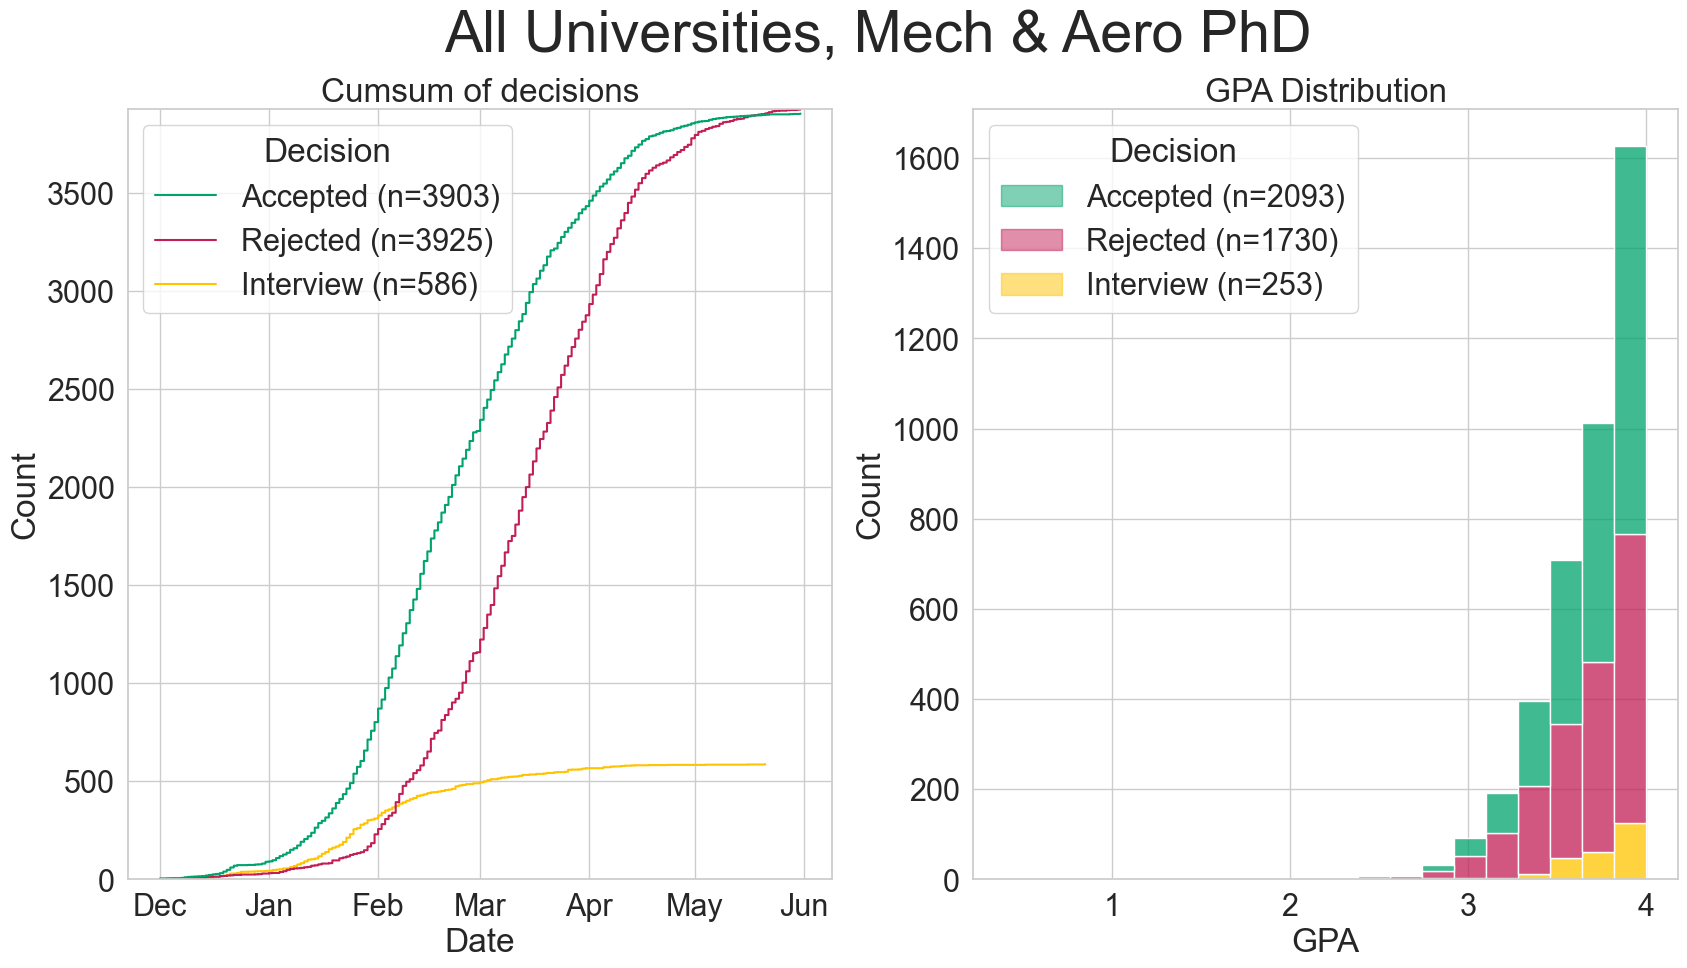

In [17]:
get_uni_stats(hisdf, histype='ecdf', title='All Universities', degree='PhD', field='Mech & Aero')

## Answering Questions

### GPA Inflation

In [18]:
hisdf['decyear'] = pd.to_numeric(hisdf['decdate'].str[-4:],errors='coerce')
hisdf = hisdf.dropna(subset=['decyear'])

hisdf['decyear'] = hisdf['decyear'].astype(np.int64)-2000

hisdf = hisdf[(hisdf['decyear'] >= 9) & (hisdf['decyear'] <= 23) & (hisdf['gpa'] <= 4)]
gpadf = hisdf[~hisdf['decyear'].isnull()].groupby(by=['decyear']).agg({'gpa': 'mean'})

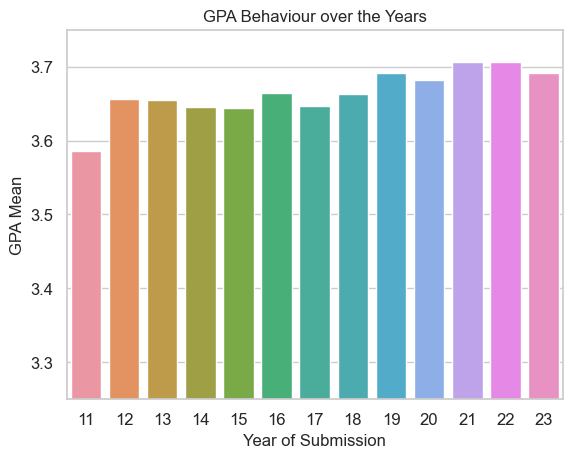

In [19]:
fig, ax = plt.subplots()
sns.barplot(x=gpadf.index,
            y=gpadf['gpa'],
            ax=ax)
ax.set_ylim([3.25, 3.75])
ax.set_xlabel("Year of Submission")
ax.set_ylabel("GPA Mean")
ax.set_title("GPA Behaviour over the Years")
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.show()

In [20]:
fig.savefig("output/gpa_inflation.png")

### Do International Students Have Significantly Different Stats?

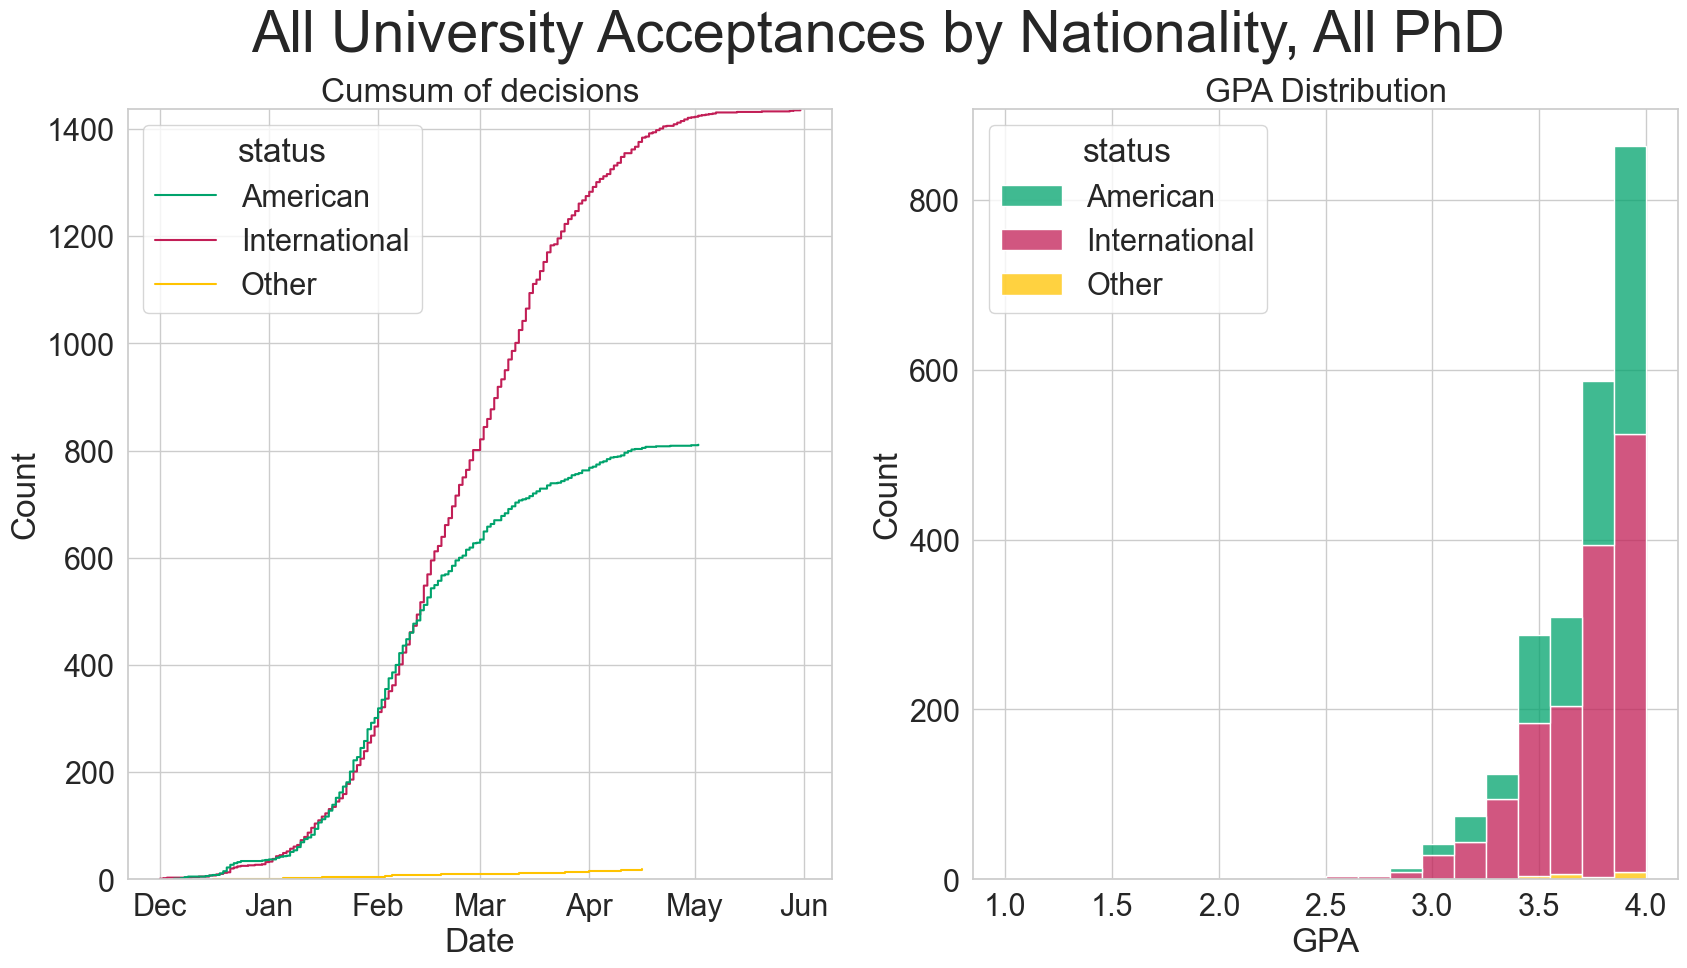

In [21]:
get_uni_stats(hisdf, histype='ecdf', title='All University Acceptances by Nationality', degree='PhD', field='All', hue='status')

### Comment analysis

This helps to visualize what people are saying most often about the program admission

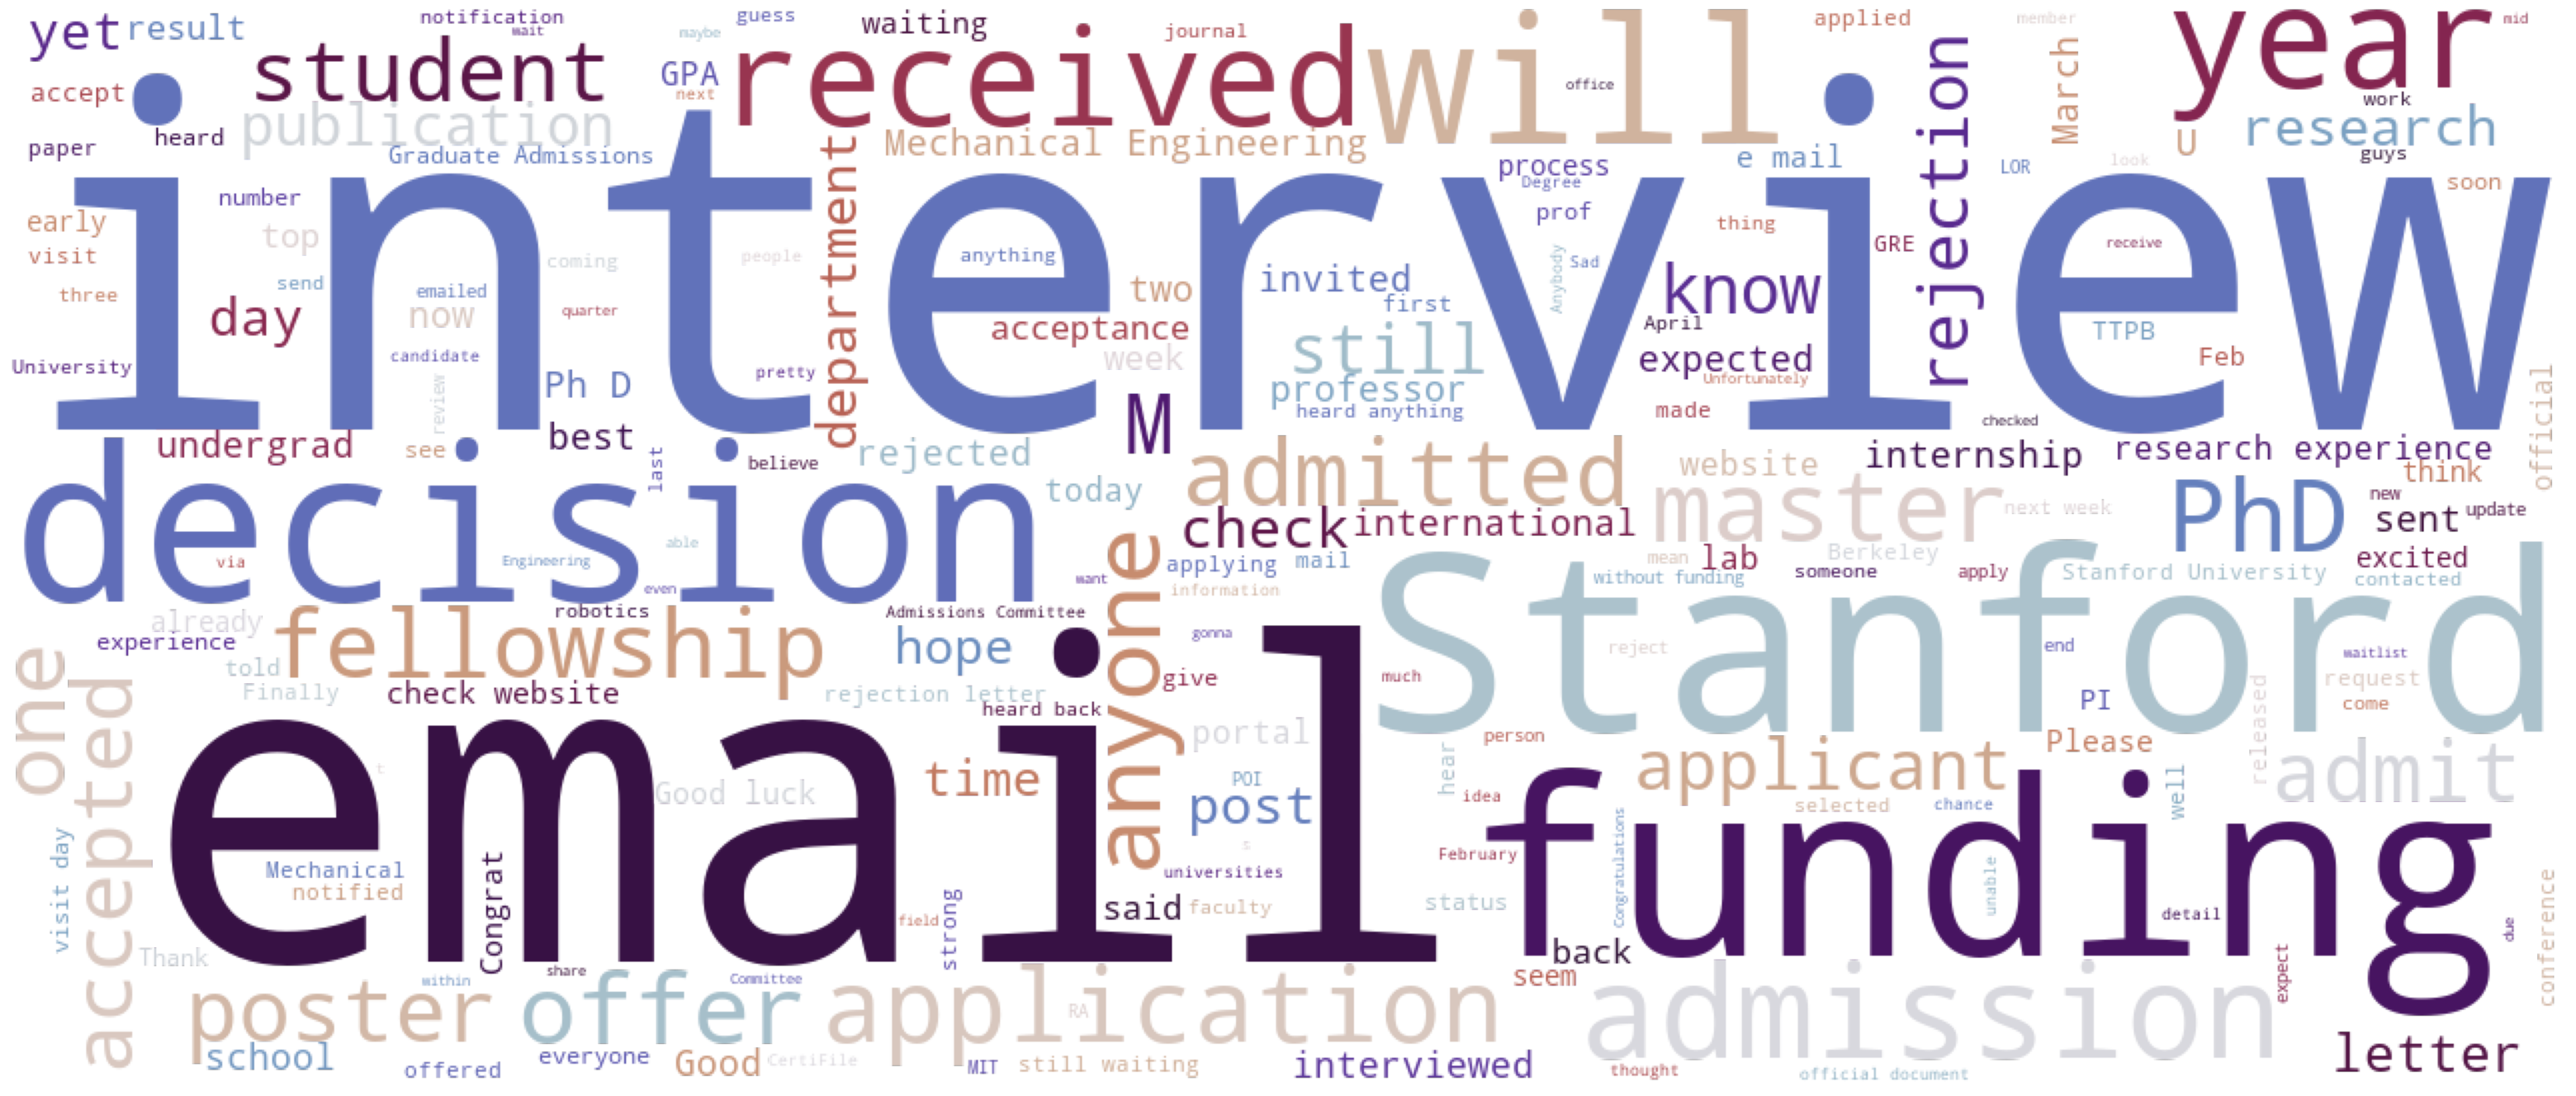

In [22]:
# function to plot wordcloud
def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 30))
    plt.imshow(wordcloud) 
    plt.axis("off");
    plt.savefig("output/wordcloud.png")

# if you want for a specific school/program then filter the df accordingly
cdf = df.loc[(df['institution'].astype(str).str.contains("Stanford"))&(df['major'].astype(str).str.contains("Mech"))]

# concat all the comments into a text chunk and clean it up
text = cdf.dropna(subset=['comment'])['comment'].str.cat(sep=' ')
text = re.sub(r'==.*?==+', '', text)
text = text.replace('\n', '')

# add some stopwords
STOPWORDS.update(['got','though','program'])
    
# print the wordcloud
wordcloud = WordCloud(width=1280,
                      height=540,
                      mode="RGBA",
                      background_color=None,
                      colormap="twilight",
                      max_font_size=270,
                      random_state=1,
                      collocations=True,
                      stopwords=STOPWORDS
                     ).generate(text)
plot_cloud(wordcloud)

### List of majors in the dataset

In [23]:
pd.options.display.max_rows = 200
hisdf['major'].value_counts()

Mechanical Engineering                        4774
Aerospace Engineering                          941
Mechanical And Aerospace Engineering           283
Advanced Mechanical Engineering                269
Department Of Mechanical Engineering           223
                                              ... 
Master Of Mechanical Engineering                 1
Security Policy Studies                          1
(EECS) Electrical And Computer Engineering       1
IME Mechanical Engineering                       1
Mechanics Of Solids And Structures               1
Name: major, Length: 525, dtype: int64